## **Import libraries**

In [1]:
import os
import numpy
import pathlib
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import Model
from keras.applications import VGG16
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Functions**

In [2]:
SEED = 999


def build_network(base_model, classes):
    """
    build a new network from a pre-trained model

    parameters:
        -base_model: pretraind model 
        -classes: number of classes to classify
    
    """
    x = Flatten()(base_model.output)
    
    x = Dense(units=256)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output


def load_images_and_labels(image_paths, target_size=(224, 224)):
    """
    Define a function that will load the images and labels in the dataset as NumPy arrays:

    parameters:
        -image_paths: images paths 
        -target_size: shape of target image  
    """
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [3]:
def main():

    dataset_path = pathlib.Path("/kaggle/input/site-dataset10")
    files_pattern = (dataset_path / 'dataset' / '*' / '*.jpg')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}
    print(CLASSES)
    
    X, y = load_images_and_labels(image_paths)
    X = X.astype('float') / 255.0
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test,y_train, y_test) = train_test_split(X, y,test_size=0.2,random_state=SEED)

    base_model = VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224,3)))

    #Freeze all the layers in the base model
    for layer in base_model.layers:  
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    #Define the batch size and a set of augmentations
    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True,width_shift_range=0.2,
    height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train,BATCH_SIZE)

    '''#warm up
    EPOCHS = 10
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-),metrics=["accuracy"])

    model.fit(train_generator,steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')
    #warm up'''

    #fine-tune the final layers of the base model
    for layer in base_model.layers[15:]:
        layer.trainable = True

    EPOCHS = 50
    model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=1e-3),metrics=['accuracy'])

    history = model.fit(train_generator,steps_per_epoch=len(X_train) // BATCH_SIZE,validation_data=(X_test, y_test),epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    #fine-tune the final layers of the base model
    
    print(f'Test accuracy: {result[1]}')
    
    # Save the model
    model_save_path = '/kaggle/working/fine_tuned_model.h5'
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")

    return history


if __name__=='__main__':
    history = main()

{'Petra', 'RomanAmphitheater', 'WadiRum', 'UmmQais', 'Ajloun', 'Jerash'}
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
92/92 [==============================] - 44s 393ms/step - loss: 1.7790 - accuracy: 0.3965 - val_loss: 1.3162 - val_accuracy: 0.5488
Epoch 2/50
92/92 [==============================] - 34s 372ms/step - loss: 1.2661 - accuracy: 0.5733 - val_loss: 0.9626 - val_accuracy: 0.6463
Epoch 3/50
92/92 [==============================] - 35s 377ms/step - loss: 1.0836 - accuracy: 0.6227 - val_loss: 0.7450 - val_accuracy: 0.7344
Epoch 4/50
92/92 [==============================] - 34s 372ms/step - loss: 1.0199 - accuracy: 0.6402 - val_loss: 0.7901 - val_accuracy: 0.7046
Epoch 5/50
92/92 [==============================] - 34s 368ms/step - loss: 0.9490 - accuracy: 0.6703 - val_loss: 0.7305 - val_accuracy: 0.7561
Epoch 6/50
92/92 [==============================] - 34s 371ms/step - loss: 0.8618 - accuracy: 0.6950 - val_loss: 0.7231 - val_accuracy: 0.7480
Epoc

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /kaggle/working/fine_tuned_model.h5


## **Plot the learning curve**

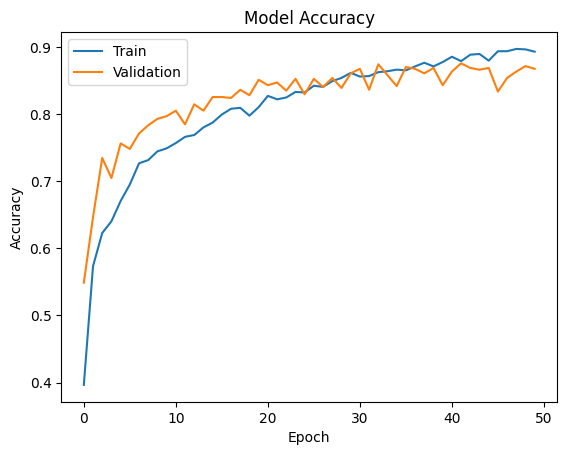

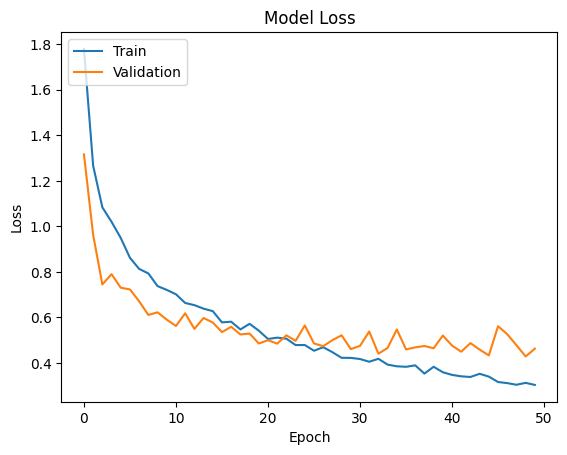

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## **Test our model**

1/1 [==============================] - 0s 173ms/step


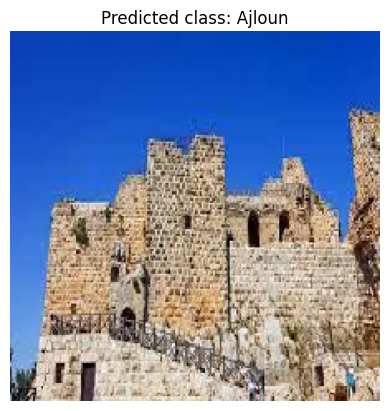

Predicted class: Ajloun
Probability for Ajloun: 0.9998
Probability for Jerash: 0.0001
Probability for Petra: 0.0000
Probability for RomanAmphitheater: 0.0000
Probability for UmmQais: 0.0000
Probability for WadiRum: 0.0000


In [8]:
# Load the saved model
loaded_model = load_model('/kaggle/working/fine_tuned_model.h5')  
# Load and preprocess a new image for prediction
original_img_path = '/kaggle/input/test-data-sites/test/a2.jpeg'  
converted_img_path = '/kaggle/working/converted_image.jpg'  

# Convert the image to JPG format
img = Image.open(original_img_path)
img = img.convert("RGB")
img.save(converted_img_path, "JPEG")  

# Load the converted image
img = image.load_img(converted_img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
predictions = loaded_model.predict(img_array)

# Assuming you have a classification task with class labels
class_labels = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]  

# Get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

# Get the probabilities for each class
class_probabilities = {label: prob for label, prob in zip(class_labels, predictions[0])}

# Plot the sample
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()

# Write predicted classes and probabilities
print(f"Predicted class: {predicted_class_label}")
for label, prob in class_probabilities.items():
    print(f"Probability for {label}: {prob:.4f}")


## **Extra Part: plot group of tesed image with actual and predicted labels**

1/1 [==============================] - 0s 19ms/step


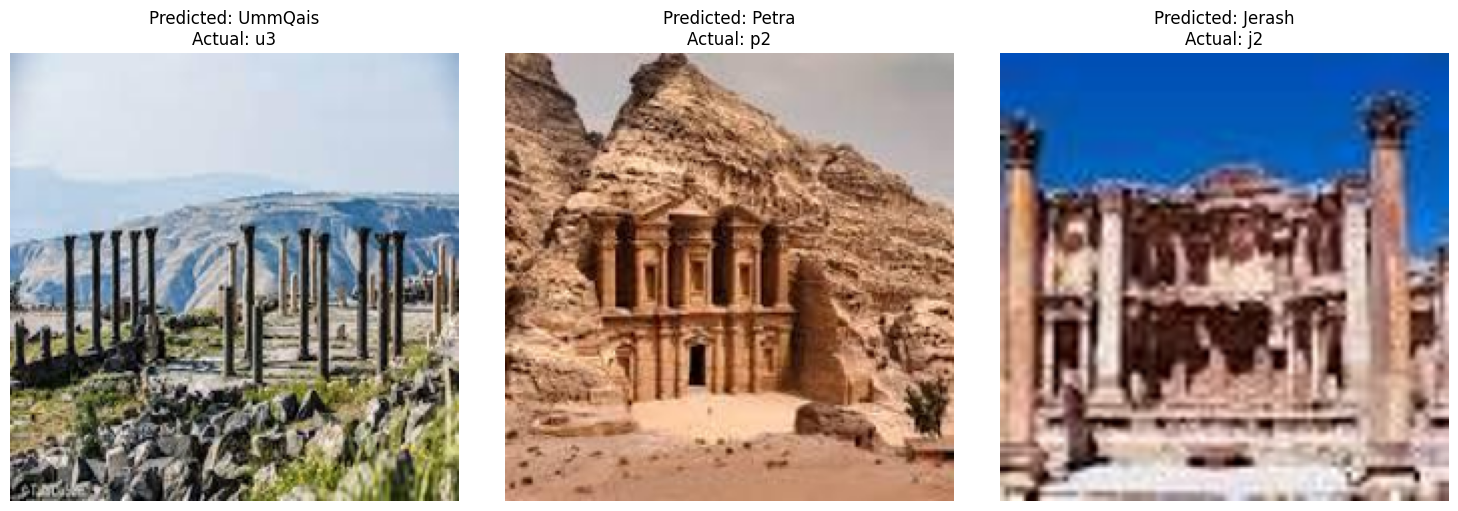

1/1 [==============================] - 0s 20ms/step


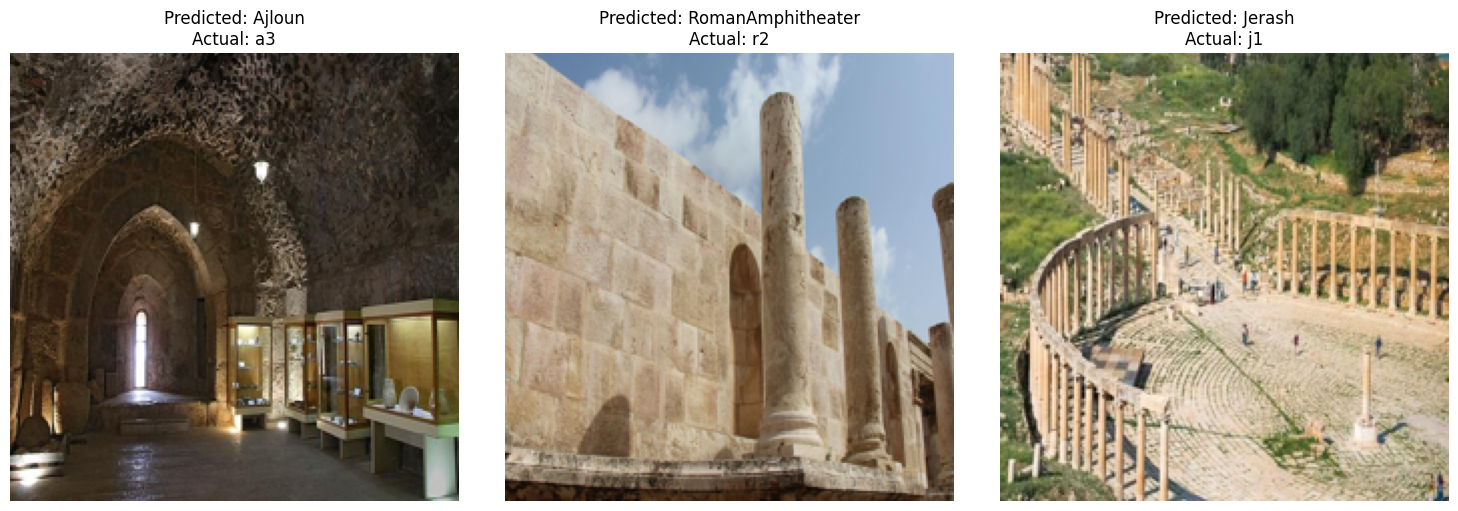

1/1 [==============================] - 0s 19ms/step


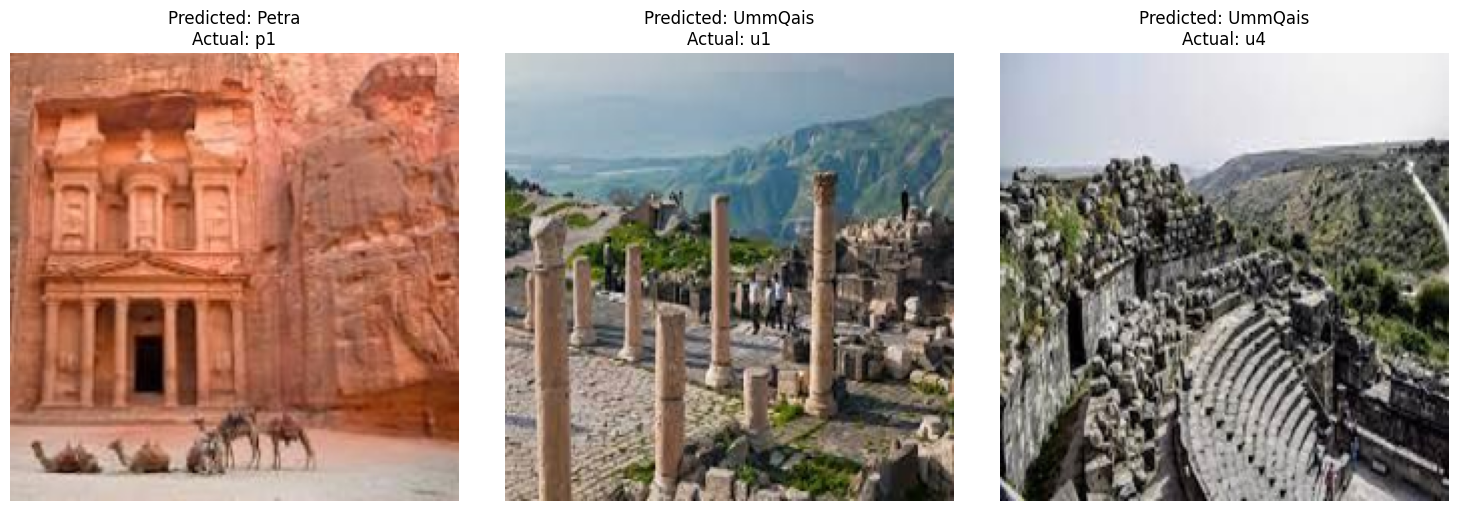

1/1 [==============================] - 0s 25ms/step


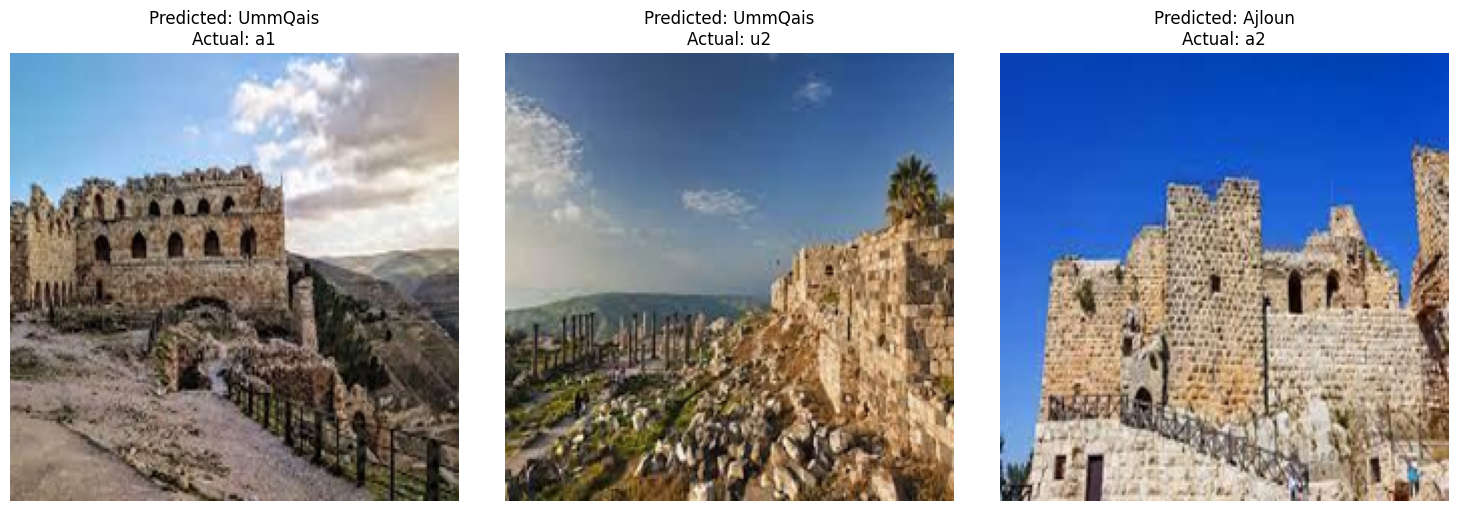

1/1 [==============================] - 0s 20ms/step


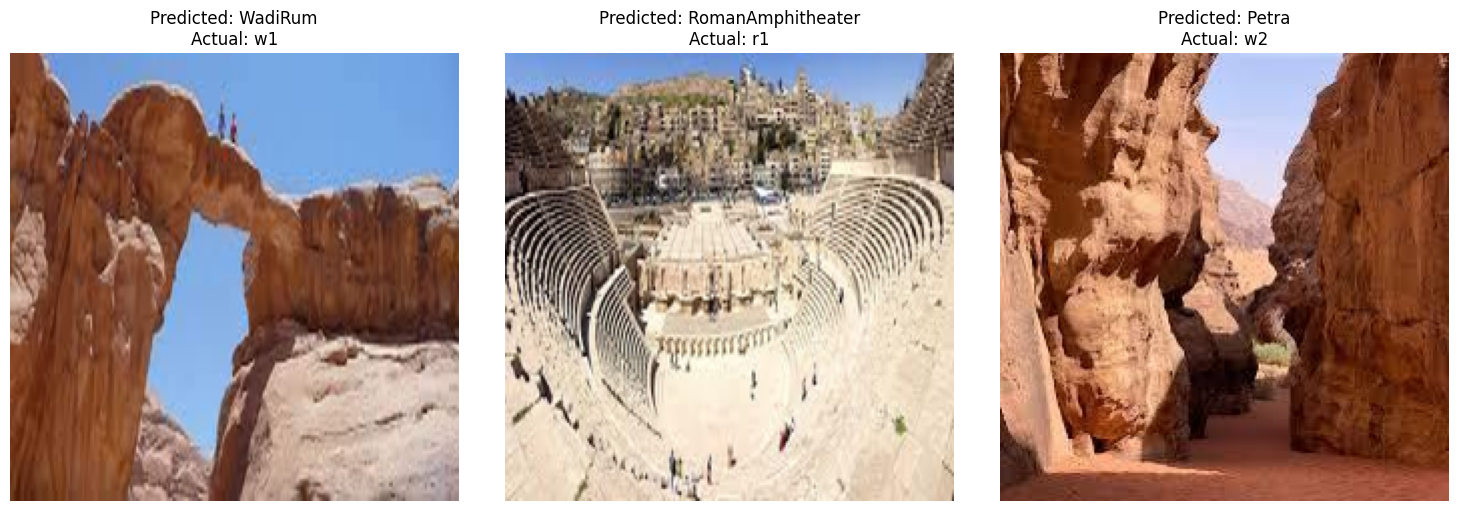

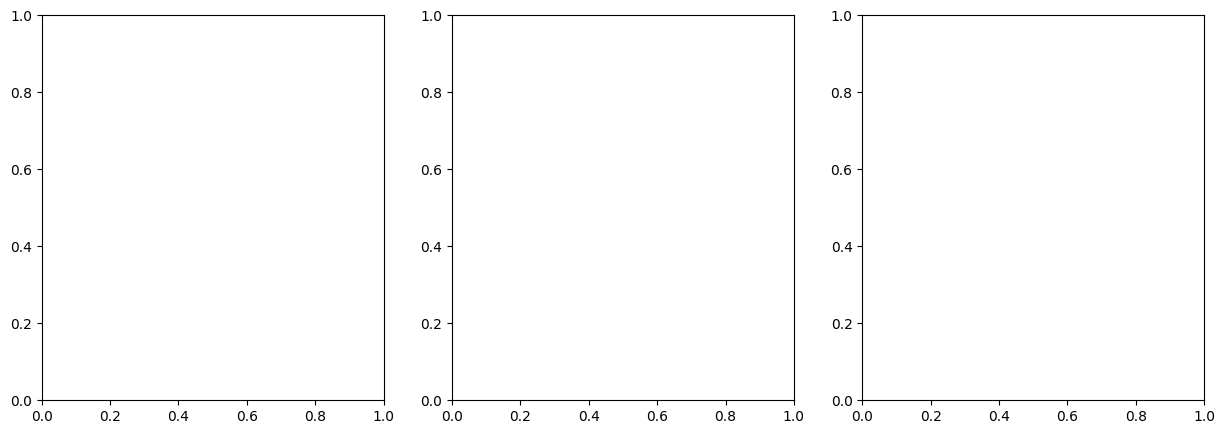

In [10]:
# Load the saved model
loaded_model = load_model('/kaggle/working/fine_tuned_model.h5')  
# Directory containing test images
test_directory = '/kaggle/input/test-data-sites/test'

# Output directory for converted images
output_directory = '/kaggle/working/converted_images/'
os.makedirs(output_directory, exist_ok=True)

class_labels = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

# Initialize counters
counter = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each image in the test directory
for filename in os.listdir(test_directory):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".webp") or filename.endswith(".png"):
        # Construct the full path to the image
        img_path = os.path.join(test_directory, filename)

        # Convert the image to JPG format and save it
        converted_img_path = os.path.join(output_directory, f"{filename.split('.')[0]}.jpg")
        img = Image.open(img_path)
        img = img.convert("RGB")
        img.save(converted_img_path, "JPEG")

        # Load and preprocess the converted image
        img = Image.open(converted_img_path)
        img = img.resize((224, 224))  
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image

        # Make a prediction
        predictions = loaded_model.predict(img_array)

        # Get the predicted class label
        predicted_class_index = np.argmax(predictions)
        predicted_class_label = class_labels[predicted_class_index]

        # Plot the image with the predicted label and actual label
        axs[counter].imshow(img)
        axs[counter].set_title(f'Predicted: {predicted_class_label}\nActual: {filename.split(".")[0]}')
        axs[counter].axis('off')

        # Increment the counter
        counter += 1

        # If three images have been plotted, reset the counter and create a new row
        if counter == 3:
            counter = 0
            plt.tight_layout()
            plt.show()
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# If there are remaining images, display them
if counter > 0:
    plt.tight_layout()
    plt.show()
